In [1]:
import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count

from os import path

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
findspark.init()
findspark.find()

'/Users/cesarivp/Documents/GitHub/TC4034.10-Big-Data/tc4034/lib/python3.13/site-packages/pyspark'

In [3]:
PATH_TO_FILE = "./data/amazon_review_polarity_csv"
FILE_NAME = "train.csv"

In [4]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/26 13:02:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
df = spark.read.csv(
    path.join(PATH_TO_FILE, FILE_NAME),
    header=False,
    inferSchema=True,
    multiLine=True,
    escape="\"",
    quote="\""
)

In [6]:
df = df.withColumnRenamed("_c0", "polarity") \
       .withColumnRenamed("_c1", "title") \
       .withColumnRenamed("_c2", "text")

In [7]:
# Show a few rows to verify
df.show(truncate=20)

+--------+--------------------+--------------------+
|polarity|               title|                text|
+--------+--------------------+--------------------+
|       2|            Amazing!|This soundtrack i...|
|       2|Excellent Soundtrack|I truly like this...|
|       2|Remember, Pull Yo...|If you've played ...|
|       2|an absolute maste...|I am quite sure a...|
|       1|        Buyer beware|This is a self-pu...|
|       2|      Glorious story|I loved Whisper o...|
|       2|    A FIVE STAR BOOK|I just finished r...|
|       2|Whispers of the W...|This was a easy t...|
|       1|          The Worst!|A complete waste ...|
|       2|          Great book|This was a great ...|
|       2|          Great Read|I thought this bo...|
|       1|           Oh please|I guess you have ...|
|       1|Awful beyond belief!|I feel I have to ...|
|       1|Don't try to fool...|It's glaringly ob...|
|       2|A romantic zen ba...|When you hear fol...|
|       2|Fashionable Compr...|After I had a D

In [8]:
df.printSchema()

root
 |-- polarity: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)



In [9]:
# 2. Number of columns
num_cols = len(df.columns)
print(f"Number of columns: {num_cols}")

Number of columns: 3


In [10]:
# 3. Number of records (rows)
num_rows = df.count()
print(f"Number of records: {num_rows}")

Number of records: 3599998


In [11]:
# 4. Data types
df.dtypes

[('polarity', 'int'), ('title', 'string'), ('text', 'string')]

In [12]:
# 5. Missing/null values per column
missing_values = df.select(
    [count(when(col(c).isNull() | isnan(c) | (col(c) == ""), c)).alias(c) for c in df.columns]
)
missing_values.show()

25/04/26 13:02:20 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+--------+-----+----+
|polarity|title|text|
+--------+-----+----+
|       0|   50|   0|
+--------+-----+----+



In [13]:
# Basic describe() statistics
df.describe(["polarity"]).show()


+-------+------------------+
|summary|          polarity|
+-------+------------------+
|  count|           3599998|
|   mean| 1.499999722222068|
| stddev|0.5000000694444089|
|    min|                 1|
|    max|                 2|
+-------+------------------+



Since title and text are strings, .describe() will mostly focus on polarity — but we can also measure average lengths of title and text.

 This will tell us:

How long titles usually are
How long full reviews usually are

In [14]:
from pyspark.sql.functions import length, avg

# Add new columns for text length
df = df.withColumn("title_length", length("title"))
df = df.withColumn("text_length", length("text"))

# Average length of title and text
df.select(
    avg("title_length").alias("avg_title_length"),
    avg("text_length").alias("avg_text_length")
).show()


+-----------------+------------------+
| avg_title_length|   avg_text_length|
+-----------------+------------------+
|24.50700898623592|405.13961257756256|
+-----------------+------------------+



Visualization

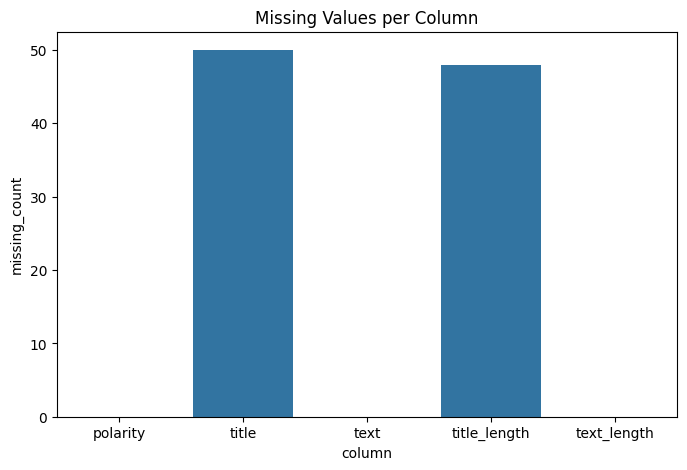

In [15]:
# 1. Missing values, not really worht it?
missing = df.select(
    [count(when(col(c).isNull() | isnan(c) | (col(c) == ""), c)).alias(c) for c in df.columns]
).toPandas()

missing = missing.T.reset_index()
missing.columns = ["column", "missing_count"]

plt.figure(figsize=(8,5))
sns.barplot(x="column", y="missing_count", data=missing)
plt.title("Missing Values per Column")
plt.show()


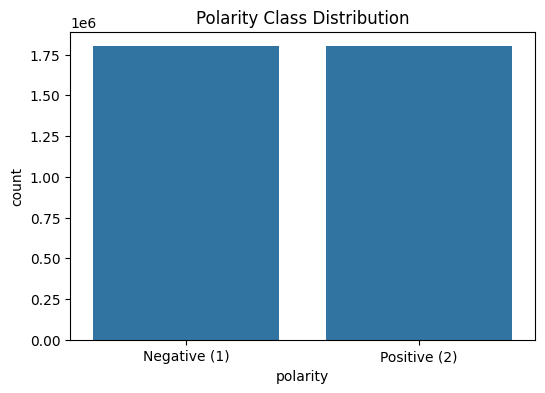

In [16]:
# 2. Class distribution chart, maybe useful? But the 1 and 2 are the same
polarity_counts = df.groupBy("polarity").count().toPandas()

plt.figure(figsize=(6,4))
sns.barplot(x="polarity", y="count", data=polarity_counts)
plt.title("Polarity Class Distribution")
plt.xticks([0, 1], ["Negative (1)", "Positive (2)"])
plt.show()